<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Task1_%E8%AE%BA%E6%96%87%E6%95%B0%E6%8D%AE%E7%BB%9F%E8%AE%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 任务说明

任务主题：论文数量统计，即统计2019年全年计算机各个方向论文数量；

任务内容：赛题的理解、使用 Pandas 读取数据并进行统计；

任务成果：学习 Pandas 的基础操作；
## 任务环境
Google Colab <br>
## 具体代码实现

## 一、从kaggle上下载arxiv数据集
**1.上传kaggle.json文件**
在kaggle账户上下载该文件

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json 

**2.安装 kaggle 在colab上**

In [2]:
!pip install -q kaggle #安装 kaggle 在colab上

**3.创建 /root/.kaggle**

In [3]:
!mkdir -p ~/.kaggle

**4.移动kaggle.json 到创建的/root/.kaggle/ 下**

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!ls ~/.kaggle

kaggle.json


In [6]:
!chmod 600 /root/.kaggle/kaggle.json

**5.开始下载arxiv.zip文件**

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

In [8]:
from google.colab import drive 

drive.mount('/content/gdrive/')  #挂载google drive 将数据集存在云盘，下次无需再次kaggle下载。

Mounted at /content/gdrive/


In [11]:
!cp -f /content/arxiv.zip  /content/gdrive/MyDrive/Colab\ Notebooks/

In [12]:
!unzip -o /content/arxiv.zip  #解压数据集

Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


## 二、数据读取

In [8]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [11]:
## 读取第一行查看数据特征
with open("arxiv-metadata-oai-snapshot.json") as f:
  for line in f:
    print(line)
    break

{"id":"0704.0001","submitter":"Pavel Nadolsky","authors":"C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan","title":"Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies","comments":"37 pages, 15 figures; published version","journal-ref":"Phys.Rev.D76:013009,2007","doi":"10.1103/PhysRevD.76.013009","report-no":"ANL-HEP-PR-07-12","categories":"hep-ph","license":null,"abstract":"  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predic

使用 enumerate() 函数为json数据加一个索引序列，以便于控制读取数据的数量。

In [12]:

# 读入数据
data  = []
#使用with语句优势：1.自动关闭文件句柄；2.自动显示（处理）文件读取数据异常
with open("arxiv-metadata-oai-snapshot.json", 'r') as f: 
    for idx, line in enumerate(f):         
        # 读取前100行，如果读取所有数据需要8G内存
        if idx >= 100:
            break        
        data.append(json.loads(line)) # 将已编码的 JSON 字符串解码为 Python 对象
        
data = pd.DataFrame(data) #将list变为dataframe格式，方便使用pandas进行分析
data.shape #显示数据大小

(100, 14)

In [13]:
data.head() #显示数据的前五行

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              100 non-null    object
 1   submitter       100 non-null    object
 2   authors         100 non-null    object
 3   title           100 non-null    object
 4   comments        87 non-null     object
 5   journal-ref     52 non-null     object
 6   doi             50 non-null     object
 7   report-no       8 non-null      object
 8   categories      100 non-null    object
 9   license         11 non-null     object
 10  abstract        100 non-null    object
 11  versions        100 non-null    object
 12  update_date     100 non-null    object
 13  authors_parsed  100 non-null    object
dtypes: object(14)
memory usage: 11.1+ KB


In [16]:

def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
                                 'report-no', 'categories', 'license', 'abstract', 'versions',
                                 'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break   
            d = json.loads(line)
            d = {col : d[col] for col in columns} # 选取需要的数据特征
            data.append(d)
    data = pd.DataFrame(data)
    return data

data = readArxivFile('arxiv-metadata-oai-snapshot.json', ['id', 'categories', 'update_date'])

## 三、数据预处理
首先粗略统计论文的种类信息：<br>
count：一列数据的元素个数；<br>
unique：一列数据中元素的种类；<br>
top：一列数据中出现频率最高的元素；<br>
freq：一列数据中出现频率最高的元素的个数；<br>

In [17]:
data["categories"].describe()

count      1796911
unique       62055
top       astro-ph
freq         86914
Name: categories, dtype: object

以上的结果表明：共有1796911个数据，有62055个子类这里仅仅是粗略统计），其中最多的种类是astro-ph，即Astrophysics（天体物理学），共出现了86914次。

In [18]:
print(data["categories"])

0                              hep-ph
1                       math.CO cs.CG
2                      physics.gen-ph
3                             math.CO
4                     math.CA math.FA
                      ...            
1796906    supr-con cond-mat.supr-con
1796907    supr-con cond-mat.supr-con
1796908    supr-con cond-mat.supr-con
1796909    supr-con cond-mat.supr-con
1796910    supr-con cond-mat.supr-con
Name: categories, Length: 1796911, dtype: object


In [19]:
#由于部分论文的类别不止一种，所以下面判断在本数据集中共出现了多少种独立的数据集。
#set() 函数创建一个无序不重复元素集，删除重复类别，统计所有类别。
unique_categories = set([i for l in [x.split(' ') for x in data["categories"]] for i in l])
#注释 先对所有类别拆分，再是两层for循环，所有行的类别特征传给l，再将拆分后的数据分开传给i，由set()函数去重处理
print(len(unique_categories))
unique_categories

176


{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'econ.EM',
 'econ.GN',
 'econ.TH',
 'eess.AS',
 'eess.IV',
 'eess.SP',
 'eess.SY',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'm

任务要求对于2019年以后的paper进行分析，所以首先对于时间特征进行预处理，从而得到2019年以后的所有种类的论文：

In [20]:
data["year"] = pd.to_datetime(data["update_date"]).dt.year #将update_date从例如2019-02-20的str变为datetime格式，并提取处year
del data["update_date"] #删除 update_date特征，其使命已完成
data = data[data["year"] >= 2019] #找出 year 中2019年以后的数据，并将其他数据删除
data.head() #查看结果


,id,categories,year
296,0704.0297,astro-ph,2019
341,0704.0342,math.AT,2019
359,0704.0360,astro-ph,2019
524,0704.0525,gr-qc,2019
534,0704.0535,astro-ph,2019


In [21]:
data.reset_index(drop=True, inplace=True) #重新编号
data

,id,categories,year
0,0704.0297,astro-ph,2019
1,0704.0342,math.AT,2019
2,0704.0360,astro-ph,2019
3,0704.0525,gr-qc,2019
4,0704.0535,astro-ph,2019
...,...,...,...
395118,quant-ph/9911051,quant-ph,2020
395119,solv-int/9511005,solv-int nlin.SI,2019
395120,solv-int/9809008,solv-int nlin.SI,2019
395121,solv-int/9909010,solv-int adap-org hep-th nlin.AO nlin.SI,2019


这里我们就已经得到了所有2019年以后的论文，下面我们挑选出计算机领域内的所有文章：

In [22]:
#爬取所有的类别
website_url = requests.get('https://arxiv.org/category_taxonomy').text #获取网页的文本数据
soup = BeautifulSoup(website_url,'lxml') #爬取数据，这里使用lxml的解析器，加速
root = soup.find('div',{'id':'category_taxonomy_list'}) #找出 BeautifulSoup 对应的标签入口
tags = root.find_all(["h2","h3","h4","p"], recursive=True) #读取 tags

#初始化 str 和 list 变量
level_1_name = ""
level_2_name = ""
level_2_code = ""
level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

#进行
for t in tags:
  if t.name == "h2":
    level_1_name = t.text
    level_2_code = t.text
    level_2_name = t.text
  elif t.name == "h3":
    raw = t.text
    level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw) #正则表达式：模式字符串：(.*)\((.*)\)；被替换字符串"\2"；被处理字符串：raw
    level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
  elif t.name == "h4":
    raw = t.text
    level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
    level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
  elif t.name == "p":
    notes = t.text
    level_1_names.append(level_1_name)
    level_2_names.append(level_2_name)
    level_2_codes.append(level_2_code)
    level_3_names.append(level_3_name)
    level_3_codes.append(level_3_code)
    level_3_notes.append(notes)


#根据以上信息生成dataframe格式的数据
df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'categories' : level_3_codes,
    'category_description': level_3_notes
    
})
#按照 "group_name" 进行分组，在组内使用 "archive_name" 进行排序
df_taxonomy.groupby(["group_name","archive_name"])
df_taxonomy

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
3,Computer Science,Computer Science,Computer Science,"Computational Engineering, Finance, and Science",cs.CE,Covers applications of computer science to the...
4,Computer Science,Computer Science,Computer Science,Computational Geometry,cs.CG,Roughly includes material in ACM Subject Class...
...,...,...,...,...,...,...
150,Statistics,Statistics,Statistics,Computation,stat.CO,"Algorithms, Simulation, Visualization"
151,Statistics,Statistics,Statistics,Methodology,stat.ME,"Design, Surveys, Model Selection, Multiple Tes..."
152,Statistics,Statistics,Statistics,Machine Learning,stat.ML,"Covers machine learning papers (supervised, un..."
153,Statistics,Statistics,Statistics,Other Statistics,stat.OT,Work in statistics that does not fit into the ...



这里主要说明一下上面代码中的正则操作，这里我们使用re.sub来用于替换字符串中的匹配项<br>

pattern : 正则中的模式字符串。<br>
repl : 替换的字符串，也可为一个函数。<br>
string : 要被查找替换的原始字符串。<br>
count : 模式匹配后替换的最大次数，默认 0 表示替换所有的匹配。<br>
flags : 编译时用的匹配模式，数字形式。<br>
其中pattern、repl、string为必选参数<br>
re.sub(pattern, repl, string, count=0, flags=0)

In [23]:
#实例如下：
import re

phone = "2004-959-559 # 这是一个电话号码"
 
# 删除注释
num = re.sub(r'#.*$', "", phone)
print ("电话号码 : ", num)
 
# 移除非数字的内容
num = re.sub(r'\D', "", phone)
print ("电话号码 : ", num)

电话号码 :  2004-959-559 
电话号码 :  2004959559


[Python3 正则表达式](https://www.runoob.com/python3/python3-reg-expressions.html)

In [24]:

re.sub(r"(.*)\((.*)\)",r"\2", " Astrophysics(astro-ph)")
# 对应的参数

# 正则中的模式字符串 pattern 的格式为 “任意字符” + “(” + "任意字符" + ")"。
# 替换的字符串 repl 为第2个分组的内容。
# 要被查找替换的原始字符串 string 为原始的爬取的数据。

'astro-ph'

[在线正则表达式测试的网站](https://tool.oschina.net/regex/)

## 四、数据分析及可视化
接下来我们首先看一下所有大类的paper数量分布：

我们使用merge函数，以两个dataframe共同的属性 “categories” 进行合并，并以 “group_name” 作为类别进行统计，统计结果放入 “id” 列中并排序。

In [25]:
_df = data.merge(df_taxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]).groupby("group_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()

_df

,group_name,id
0,Physics,79985
1,Mathematics,51567
2,Computer Science,40067
3,Statistics,4054
4,Electrical Engineering and Systems Science,3297
5,Quantitative Biology,1994
6,Quantitative Finance,826
7,Economics,576


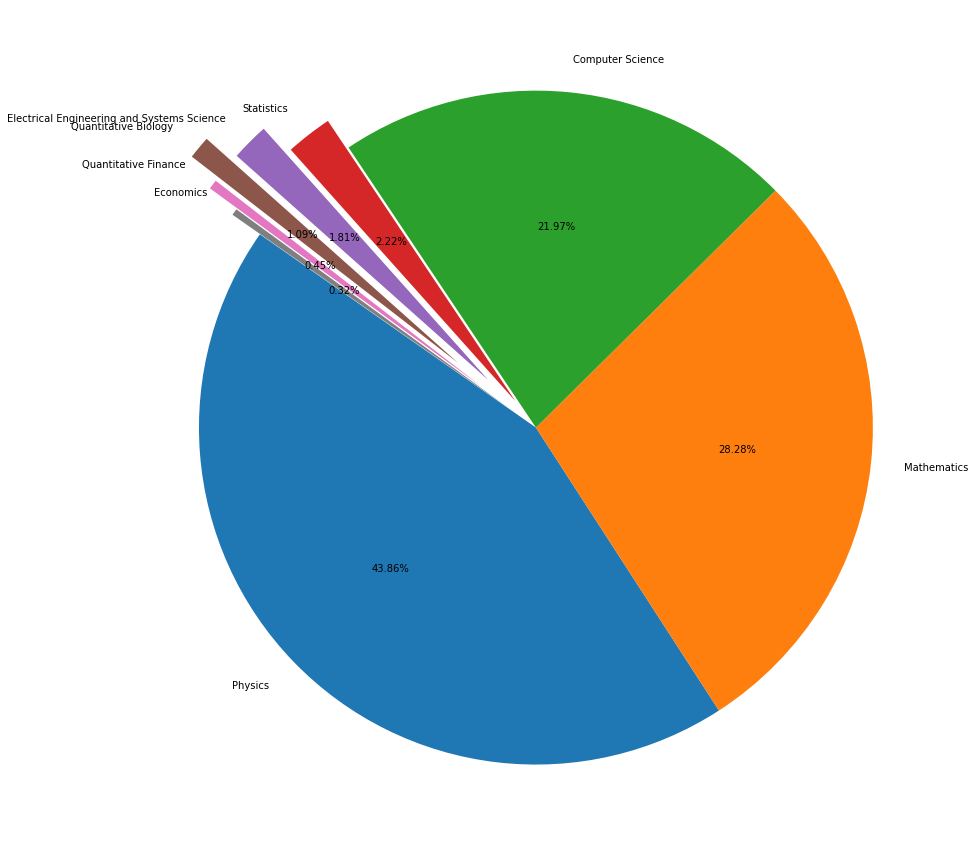

In [ ]:
#下面使用饼图进行上图结果的可视化：
fig = plt.figure(figsize=(15,12))
explode = (0, 0, 0, 0.1, 0.2, 0.3, 0.2, 0.1) 
plt.pie(_df["id"],  labels=_df["group_name"], autopct='%1.2f%%', startangle=145, explode=explode)
plt.tight_layout()
plt.show()

统计在计算机各个子领域2019年后的paper数量，我们同样使用 merge 函数，对于两个dataframe 共同的特征 categories 进行合并并且进行查询。然后我们再对于数据进行统计和排序从而得到以下的结果：

In [26]:
group_name="Computer Science"
cats = data.merge(df_taxonomy, on="categories").query("group_name == @group_name")
data1 = cats.groupby(["year","category_name"]).count().reset_index().pivot(index="category_name", columns="year",values="id")

In [27]:
data1

year,2019,2020
category_name,,
Artificial Intelligence,558,757
Computation and Language,2153,2906
Computational Complexity,131,188
"Computational Engineering, Finance, and Science",108,205
Computational Geometry,199,216
Computer Science and Game Theory,281,323
Computer Vision and Pattern Recognition,5559,6517
Computers and Society,346,564
Cryptography and Security,1067,1238


In [28]:
data1.columns

Int64Index([2019, 2020], dtype='int64', name='year')

In [29]:
data1.index

Index(['Artificial Intelligence', 'Computation and Language',
       'Computational Complexity',
       'Computational Engineering, Finance, and Science',
       'Computational Geometry', 'Computer Science and Game Theory',
       'Computer Vision and Pattern Recognition', 'Computers and Society',
       'Cryptography and Security', 'Data Structures and Algorithms',
       'Databases', 'Digital Libraries', 'Discrete Mathematics',
       'Distributed, Parallel, and Cluster Computing', 'Emerging Technologies',
       'Formal Languages and Automata Theory', 'General Literature',
       'Graphics', 'Hardware Architecture', 'Human-Computer Interaction',
       'Information Retrieval', 'Logic in Computer Science',
       'Machine Learning', 'Mathematical Software', 'Multiagent Systems',
       'Multimedia', 'Networking and Internet Architecture',
       'Neural and Evolutionary Computing', 'Numerical Analysis',
       'Operating Systems', 'Other Computer Science', 'Performance',
       'Prog

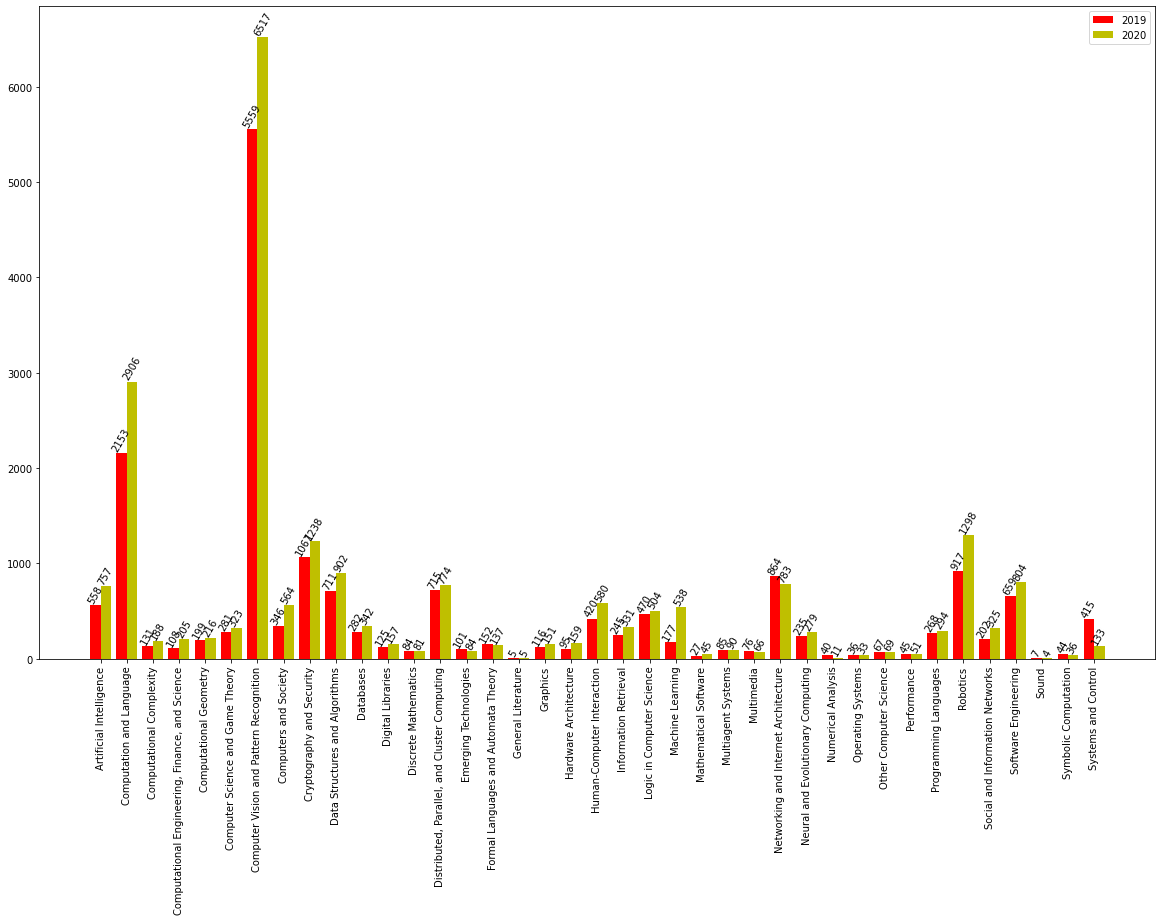

In [30]:
import numpy as np
fig = plt.figure(figsize=(20,12))
bar_width=0.4#设置柱状图的宽度
X = np.arange(len(data1.values[:,1]))
tick_label = ['Artificial Intelligence', 'Computation and Language',
              'Computational Complexity',
              'Computational Engineering, Finance, and Science',
              'Computational Geometry', 'Computer Science and Game Theory',
              'Computer Vision and Pattern Recognition', 'Computers and Society',
              'Cryptography and Security', 'Data Structures and Algorithms',
              'Databases', 'Digital Libraries', 'Discrete Mathematics',
              'Distributed, Parallel, and Cluster Computing', 'Emerging Technologies',
              'Formal Languages and Automata Theory', 'General Literature',
              'Graphics', 'Hardware Architecture', 'Human-Computer Interaction',
              'Information Retrieval', 'Logic in Computer Science',
              'Machine Learning', 'Mathematical Software', 'Multiagent Systems',
              'Multimedia', 'Networking and Internet Architecture',
              'Neural and Evolutionary Computing', 'Numerical Analysis',
              'Operating Systems', 'Other Computer Science', 'Performance',
              'Programming Languages', 'Robotics', 'Social and Information Networks',
              'Software Engineering', 'Sound', 'Symbolic Computation',
              'Systems and Control']

#显示每个柱的具体高度
for x,y in zip(X,data1.values[:,0]):
    plt.text(x,y+0.005,'%d' %y, ha='center',va='bottom',rotation=60)

for x,y1 in zip(X,data1.values[:,1]):
    plt.text(x+bar_width,y1+0.005,'%d' %y1, ha='center',va='bottom',rotation=60)


plt.bar(X, data1.values[:,0],bar_width,label='2019', fc = 'r')
plt.bar(X+bar_width,data1.values[:,1],bar_width,label='2020', fc = 'y')
plt.xticks(X+bar_width/2,tick_label,rotation=90)
plt.legend()
plt.show()

## 原教程链接：[Datawhale](https://github.com/datawhalechina/team-learning-data-mining/blob/master/AcademicTrends/Task1%20%E8%AE%BA%E6%96%87%E6%95%B0%E6%8D%AE%E7%BB%9F%E8%AE%A1.ipynb)
